In [33]:
import numpy as np
import matplotlib.pyplot as plt
from ase import *
from ase.io import read
from gpaw import *

from ase.units import Hartree
from gpaw.utilities.dos import LCAODOS, RestartLCAODOS, fold


from gpaw.lcao.pwf2 import LCAOwrap
from matplotlib.colors import LinearSegmentedColormap, LogNorm
from qtpyt.basis import Basis
from qtpyt.lo.tools import rotate_matrix, subdiagonalize_atoms, lowdin_rotation
from ase.io import read
from qtpyt.basis import Basis


### Helper functions

In [34]:
def get_species_indices(atoms,species):
    indices = []
    for element in species:
        element_indices = atoms.symbols.search(element)
        indices.extend(element_indices)
    return sorted(indices)

def plot_atomic_positions_by_species(atoms, element_colors):
    fig, ax = plt.subplots(figsize=(5, 10))
    positions = atoms.positions
    x = positions[:, 0]
    y = positions[:, 1]

    colors = [element_colors[atom.symbol] for atom in atoms]

    ax.scatter(x, y, color=colors, s=300)

    for i, (xi, yi) in enumerate(zip(x, y)):
        ax.text(xi, yi, str(i), color='black', fontsize=9, ha='center', va='center')


    ax.set_xlabel('X position')
    ax.set_ylabel('Y position')
    ax.set_title('Atomic Positions by Species')

    plt.show()

def create_active_hamiltonian(H, S,  index_active_region):
    # Create a list of indices to retain
    indices_to_keep = sorted(list(index_active_region))

    # Create the H_active matrix by extracting the relevant rows and columns
    H_active = H[np.ix_(indices_to_keep, indices_to_keep)]
    S_active = S[np.ix_(indices_to_keep, indices_to_keep)]

    return H_active, S_active


## Visualize structure and how the atoms are ordered

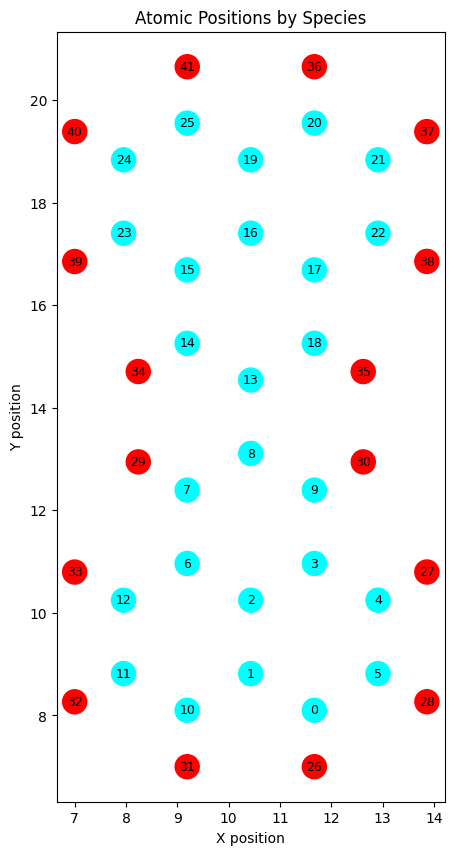

In [35]:
atoms = read('./struct.xyz')
element_colors = {'C':'cyan','H':'red'}

plot_atomic_positions_by_species(atoms, element_colors)

### Check DFT calculations

In [4]:
gpaw_file = './struct.gpw'
calc = GPAW(gpaw_file, txt=None)
dos = RestartLCAODOS(calc)
pdos = LCAODOS(calc)


-3.700479276499313

In [ ]:
E_fermi = calc.get_fermi_level()
E_fermi

In [17]:
calc.get_default_parameters()

{'mode': 'fd',
 'xc': 'LDA',
 'occupations': None,
 'poissonsolver': None,
 'h': None,
 'gpts': None,
 'kpts': [(0.0, 0.0, 0.0)],
 'nbands': None,
 'charge': 0,
 'setups': {},
 'basis': {},
 'spinpol': None,
 'filter': None,
 'mixer': None,
 'eigensolver': None,
 'background_charge': None,
 'experimental': {'reuse_wfs_method': 'paw',
  'niter_fixdensity': 0,
  'magmoms': None,
  'soc': None,
  'kpt_refine': None},
 'external': None,
 'random': False,
 'hund': False,
 'maxiter': 333,
 'symmetry': {'point_group': True,
  'time_reversal': True,
  'symmorphic': True,
  'tolerance': 1e-07,
  'do_not_symmetrize_the_density': None},
 'convergence': {'energy': 0.0005,
  'density': 0.0001,
  'eigenstates': 4e-08,
  'bands': 'occupied'},
 'verbose': 0,
 'fixdensity': False,
 'dtype': None}

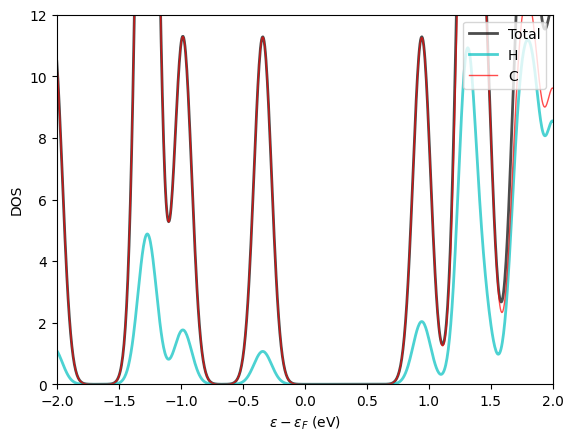

In [66]:
atoms_C_index = np.where(atoms.symbols == 'C')[0]
atoms_H_index = np.where(atoms.symbols == 'H')[0]
num_C_atoms = len(atoms_C_index)
num_H_atoms = len(atoms_H_index)


C_orbitals = pdos.get_atom_indices(atoms_C_index)
H_orbitals = pdos.get_atom_indices(atoms_H_index)

num_spherical_harmonics_C = 13
num_spherical_harmonics_H = 5

tot_basis_func = num_spherical_harmonics_C * num_C_atoms + num_spherical_harmonics_H * num_H_atoms

energies, weights = dos.get_subspace_pdos(range(tot_basis_func))
e, w = fold(energies * Hartree, weights, 5000, 0.1)

e, C_pdos = dos.get_subspace_pdos(C_orbitals)
e, C_pdos = fold(e * Hartree, C_pdos, 5000, 0.1)
e, H_pdos = dos.get_subspace_pdos(H_orbitals)
e, H_pdos = fold(e * Hartree, H_pdos, 5000, 0.1)

plt.plot(e , w, label='Total', c='k', lw=2, alpha=0.7)
plt.plot(e , H_pdos, label='H', c='c', lw=2, alpha=0.7)
plt.plot(e , C_pdos, label='C', c='r', lw=1, alpha=0.7)

plt.axis(
    ymin=0.,
    ymax=12.0,
    xmin=-2,
    xmax=2,
)
plt.xlabel(r'$\epsilon - \epsilon_F \ \rm{(eV)}$')
plt.ylabel('DOS')
plt.legend(loc=1)

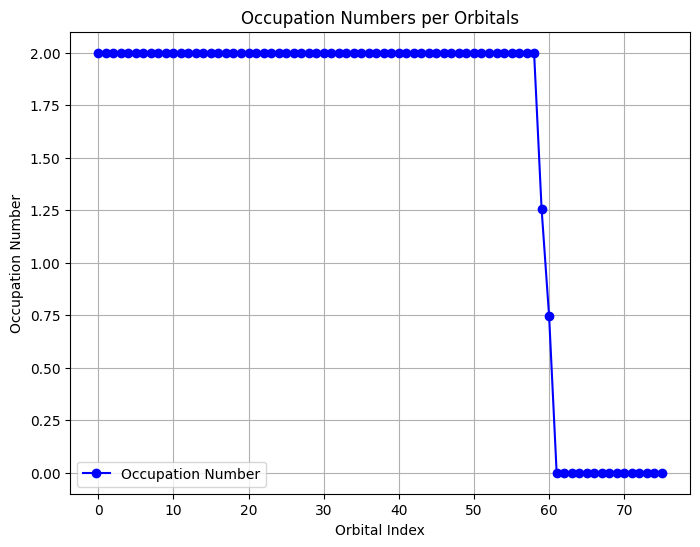

In [6]:
occ = calc.get_occupation_numbers()
# Plot the occupation numbers
plt.figure(figsize=(8, 6))
plt.plot(range(len(occ)), occ, 'bo-', label='Occupation Number')

# Label the plot
plt.title('Occupation Numbers per Orbitals')
plt.xlabel('Orbital Index')
plt.ylabel('Occupation Number')
plt.ylim([-0.1, 2.1])  # Occupation numbers typically range between 0 and 2
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

#### Visualize the states

In [28]:
# Get all eigenvalues
eigenvalues = calc.get_eigenvalues()

# Find the band index of HOMO and LUMO by matching with eigenvalues
homo_index = np.where(np.isclose(eigenvalues, homo_energy))[0][0]
lumo_index = np.where(np.isclose(eigenvalues, lumo_energy))[0][0]

print(f"HOMO band index: {homo_index}")
print(f"LUMO band index: {lumo_index}")

HOMO band index: 59
LUMO band index: 60


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


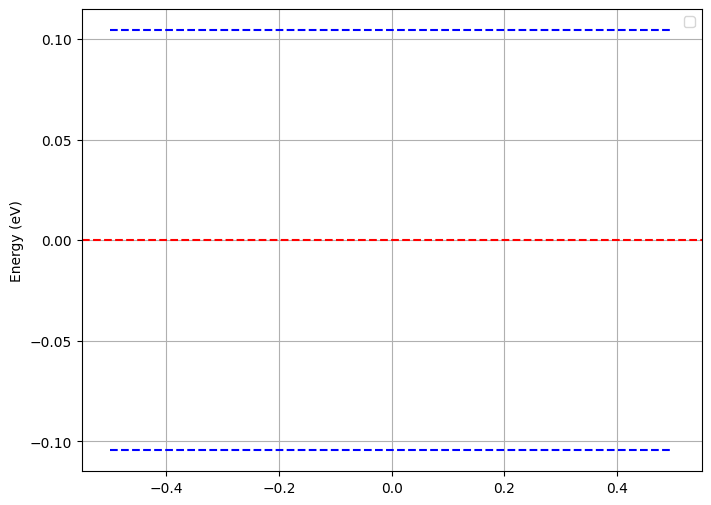

In [32]:
# Define how many states above and below the Fermi level to plot
n_valence = 0
n_conduction = 1

# Select indices for the eigenstates ±n around the Fermi level
start_index = max(homo_index - n_valence, 0)  # Ensure index does not go below zero
end_index = min(lumo_index + n_conduction, len(eigenvalues))  # Ensure index does not go above the total number of eigenstates
selected_indices = np.arange(start_index, end_index)

# Plot the eigenvalues
plt.figure(figsize=(8, 6))
x_min, x_max = -0.5, 0.5

for idx in selected_indices:
    energy = eigenvalues[idx]
    energy -= E_fermi # Move Fermi to 0 eV
    # Plot a horizontal line at each eigenvalue with finite width along x
    plt.hlines(energy, x_min, x_max, colors='blue', linestyles='--')
plt.axhline(0, color='red', linestyle='--')


plt.ylabel('Energy (eV)')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
homo_energy, lumo_energy = calc.get_homo_lumo()

# Calculate the HOMO-LUMO gap
homo_lumo_gap = lumo_energy - homo_energy

print(f"HOMO energy: {homo_energy - E_fermi} eV")
print(f"LUMO energy: {lumo_energy -  E_fermi} eV")
print(f"HOMO-LUMO gap: {homo_lumo_gap} eV")

HOMO energy: -0.10443745918617608 eV
LUMO energy: 0.10443688989599798 eV
HOMO-LUMO gap: 0.20887434908217406 eV


### Get Hamiltonian and Overlap matrices in the LCAO basis

In [7]:
# Since this is a molecule, I've performed a Gamma point calculation and the assumption is the H_gamma is equivalent to a real space Hamiltonian H_R.

lcao = LCAOwrap(calc)
H_lcao = lcao.get_hamiltonian()
S_lcao = lcao.get_overlap()

# Move Fermi to 0 eV

H_lcao -= E_fermi * S_lcao

Condition number: 5.4e+04


### Get Hamiltonian and Overlap matrices in the LO basis and Pick out only C 2pz orbitals 

I know a priori that, of the 13 orbitals of C, index '3' corresponds to C 2pz. This is based on visualizing the LOs cube files. If you are interested in, for example, the 1s orbitals, visualize the cube files for the orbitals and find which index produced a cube file that shows 1s behavior. The following calculation shows how to extract only the C 2pz contributions to the Hamiltonian

In [95]:
# Perform subdiagonalization

nao_a = np.array([setup.nao for setup in calc.wfs.setups])
basis = Basis(atoms, nao_a)

SUBDIAG_SPECIES = ("C", "H")
subdiag_indices = get_species_indices(atoms, SUBDIAG_SPECIES)

# Extract the basis for the subdiagonalized region and get their indices
basis_subdiag_region = basis[subdiag_indices]
index_subdiag_region = basis_subdiag_region.get_indices()

# Define the active region within the subdiagonalized species (C 2 pz in this case)
active = {'C':[3]}
extract_active_region = basis_subdiag_region.extract().take(active)
index_active_region = index_subdiag_region[extract_active_region]

Usub, eig = subdiagonalize_atoms(basis, H_lcao, S_lcao, a=subdiag_indices)

for idx in index_active_region:
    if Usub[idx-1,idx] < 0.: # change sign
        Usub[:,idx] *= -1

# Rotate matrices
H_subdiagonal = rotate_matrix(H_lcao, Usub)
S_subdiagonal = rotate_matrix(S_lcao, Usub)

lowdin = True
if lowdin:
    Ulow = lowdin_rotation(H_subdiagonal, S_subdiagonal, index_active_region)

    H_subdiagonal = rotate_matrix(H_subdiagonal, Ulow)
    S_subdiagonal = rotate_matrix(S_subdiagonal, Ulow)

H_active, S_active = create_active_hamiltonian(H_subdiagonal, S_subdiagonal, index_active_region)

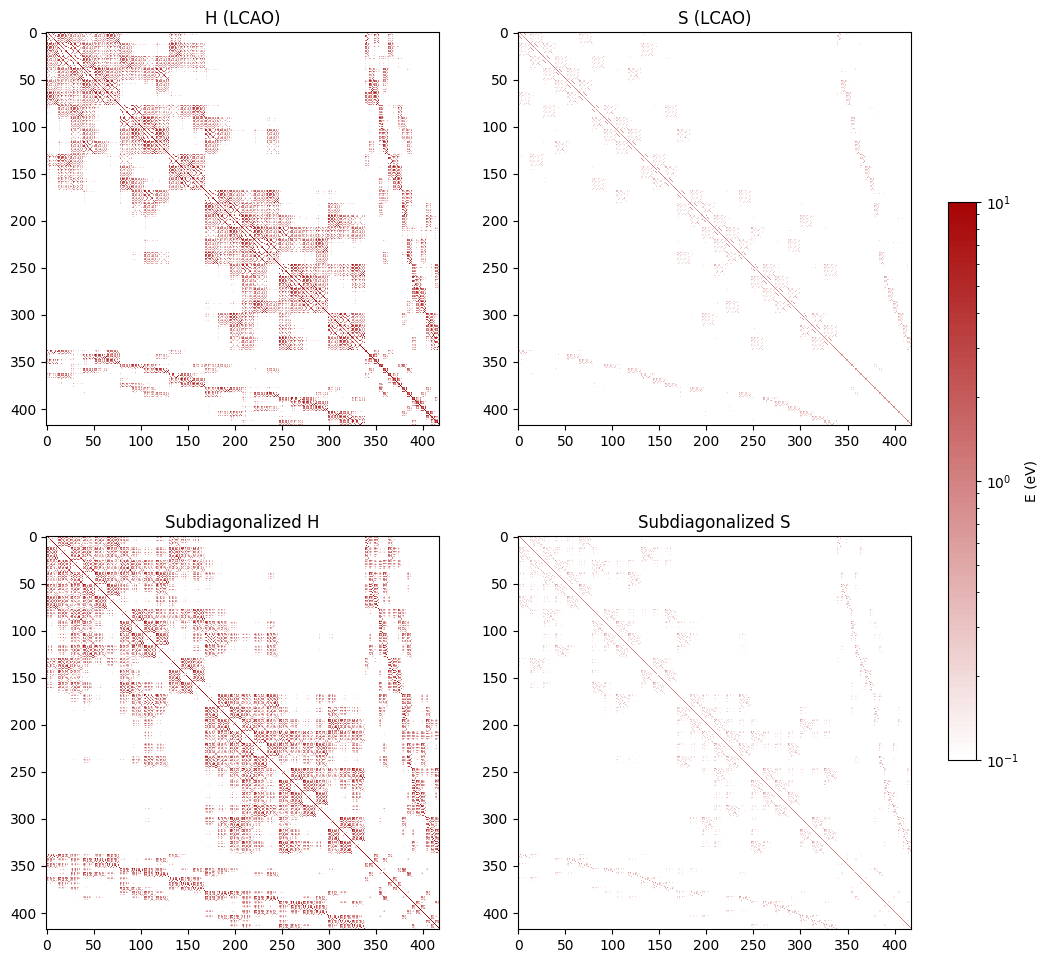

In [96]:
# Note that I'm plotting the absolute values in H and S for ease of visualization.

cmap_name = 'custom_white_red'
colors = [(1, 1, 1), (166/255, 4/255, 4/255)]
n_bins = 100
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
norm = LogNorm(vmin=0.1, vmax=10)

# Create a figure with 2 rows and 2 columns of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Plot H_lcao in the first row, first column
cax1 = axs[0, 0].imshow(np.abs(H_lcao), interpolation='nearest', cmap=cm, norm=norm)
axs[0, 0].set_title("H (LCAO)")

# Plot S_lcao in the first row, second column
cax2 = axs[0, 1].imshow(np.abs(S_lcao), interpolation='nearest', cmap=cm, norm=norm)
axs[0, 1].set_title("S (LCAO)")

# Plot H_subdiagonal in the second row, first column
cax3 = axs[1, 0].imshow(np.abs(H_subdiagonal), interpolation='nearest', cmap=cm, norm=norm)
axs[1, 0].set_title("Subdiagonalized H")

# Plot S_subdiagonal in the second row, second column
cax4 = axs[1, 1].imshow(np.abs(S_subdiagonal), interpolation='nearest', cmap=cm, norm=norm)
axs[1, 1].set_title("Subdiagonalized S")

# Add a shared colorbar for all subplots
cbar = fig.colorbar(cax4, ax=axs, orientation='vertical', fraction=0.03, pad=0.04)
cbar.set_label('E (eV)')

plt.show()

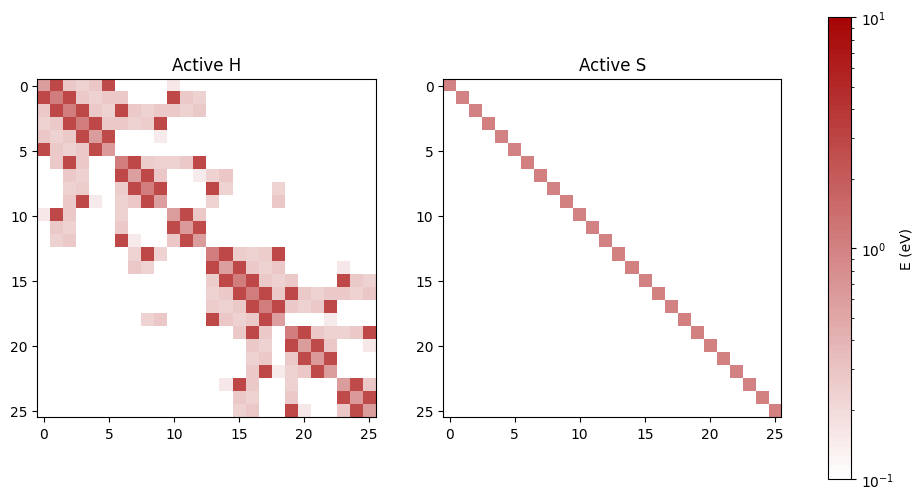

In [97]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the subdiagonalized H matrix for the bridge region
cax1 = ax1.imshow(np.abs(H_active), interpolation='nearest', cmap=cm, norm=norm)
ax1.set_title("Active H")

# Plot the subdiagonalized S matrix for the bridge region
cax2 = ax2.imshow(np.abs(S_active), interpolation='nearest', cmap=cm, norm=norm)
ax2.set_title("Active S")

# Add a shared colorbar
cbar = fig.colorbar(cax2, ax=[ax1, ax2], orientation='vertical')
cbar.set_label('E (eV)')

plt.show()


Based on the ordering of the indices in the visualization of the structure (top of the notebook), and the naming convention in the figure below,

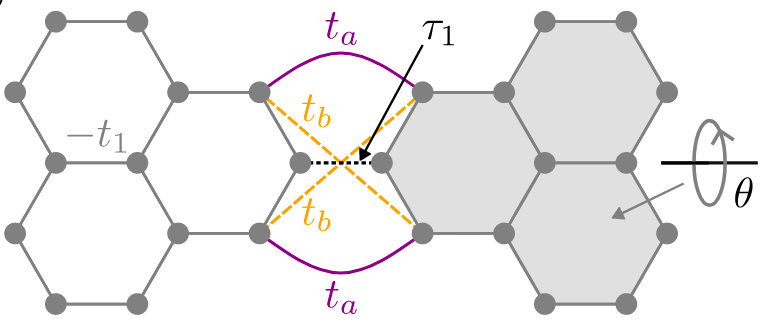

1. t_1 = hopping between atom #1 and #2
2. tau_1 = hopping between atom #8 and #13
3. t_a = hopping between atom #7 and #14
4. t_b = hopping between atom #7 and #18

In [98]:
ta = H_active[7,14]
tb = H_active[7,18]
bandgap = (2/3)*abs(ta - tb)

print("t1 = ",H_active[1,2])
print("tau_1 = ",H_active[8,13])
print("ta = ",ta)
print("tb = ",tb)
print("2/3|ta - tb|=",bandgap)

# Onsite C pz-pz terms
print("onsite = ",np.diag(H_active))

t1 =  -2.842862258332445
tau_1 =  -2.845015725118648
ta =  -0.28263153559685034
tb =  0.050837667639309865
2/3|ta - tb|= 0.22231280215744012
onsite =  [0.61098436 1.08141793 1.05743511 1.08035965 0.61079034 0.64039125
 1.07885018 0.59015293 1.09410579 0.58946821 0.61282481 0.64165431
 0.60994354 1.09454725 0.58952474 1.08100086 1.0574999  1.07913426
 0.58902741 1.08474919 0.61251255 0.64150236 0.61136527 0.61067826
 0.64012319 0.61438416]


In [99]:
# Diagonalize the Hermitian Hamiltonian using eigh (eigenvalues are automatically sorted)
eigenvalues, eigenvectors = np.linalg.eigh(H_active)

# Since the H_active has dimensions 26 X 26 and there are 2 electrons per state, 13 states are occupied and 13 are unoccupied.
lumo_index = int(np.shape(H_active)[0]/2)
homo_index = lumo_index - 1

homo_energy = eigenvalues[homo_index]
lumo_energy = eigenvalues[lumo_index]

# Calculate the HOMO-LUMO gap
homo_lumo_gap = lumo_energy - homo_energy

print(f"HOMO energy: {homo_energy} eV")
print(f"LUMO energy: {lumo_energy} eV")
print(f"HOMO-LUMO gap: {homo_lumo_gap} eV")

HOMO energy: 0.13505977698749885 eV
LUMO energy: 0.35294166172771596 eV
HOMO-LUMO gap: 0.2178818847402171 eV


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


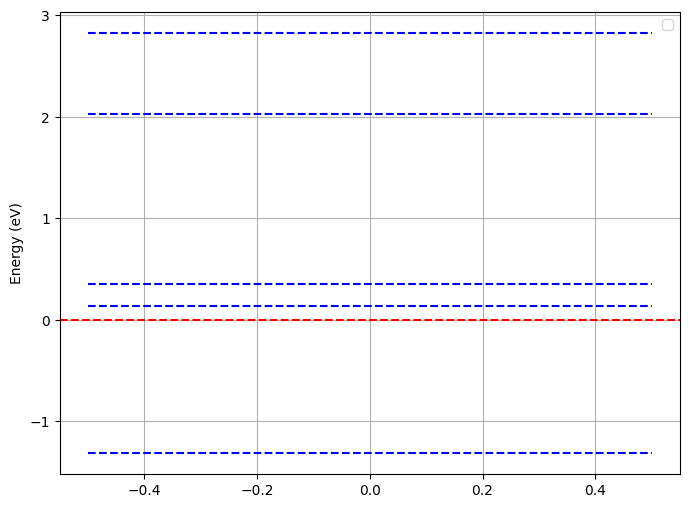

In [100]:
fermi_level = 0

# Find the index of the state closest to the Fermi level (E_fermi)
fermi_index = np.argmin(np.abs(eigenvalues - fermi_level))


# Define how many states above and below the Fermi level to plot
n_valence = 1
n_conduction = 3

# Select indices for the eigenstates ±n around the Fermi level
start_index = max(fermi_index - n_valence, 0)  # Ensure index does not go below zero
end_index = min(fermi_index + n_conduction + 1, len(eigenvalues))  # Ensure index does not go above the total number of eigenstates
selected_indices = np.arange(start_index, end_index)

# Plot the eigenvalues
plt.figure(figsize=(8, 6))
x_min, x_max = -0.5, 0.5

for idx in selected_indices:
    energy = eigenvalues[idx]
    # Plot a horizontal line at each eigenvalue with finite width along x
    plt.hlines(energy, x_min, x_max, colors='blue', linestyles='--')
plt.axhline(0, color='red', linestyle='--')


plt.ylabel('Energy (eV)')
plt.legend()
plt.grid(True)
plt.show()

In [101]:
eigenvalues

array([-5.49084595, -5.30695358, -4.43358636, -3.89756181, -3.8783915 ,
       -3.62472125, -2.66133251, -2.18514432, -2.07256379, -2.06451182,
       -2.05468168, -1.31325472,  0.13505978,  0.35294166,  2.02609271,
        2.82256908,  2.83663969,  2.85893544,  3.09331214,  3.84697432,
        5.25735059,  5.64550799,  5.745476  ,  6.87878331,  8.82123809,
        9.2670963 ])